Notebook by prof. Rebecca Fiebrink and Terence Broad
# Session 12: Classification with bag of words

In this notebook we are going to perform classification on a text dataset using bag of words features. There is a similiar notebook to this that uses LDA topic modelling features for classification. 

This notebook uses the [Myers-Briggs comments dataset](https://git.arts.ac.uk/tbroad/myers-briggs-comments-dataset) that is scraped from the website [16personalities.com](https://www.16personalities.com/) using [this web-crawling code](https://git.arts.ac.uk/tbroad/web-scrape-myers-briggs). The [Myers-Briggs personality typology](https://en.wikipedia.org/wiki/Myers%E2%80%93Briggs_Type_Indicator) is a categorisation for personality types that result from a questionnaire that asks people how they make decision and percieve the world. The questionnaire breaks people down into 16 personality types, made up of four binary categories:


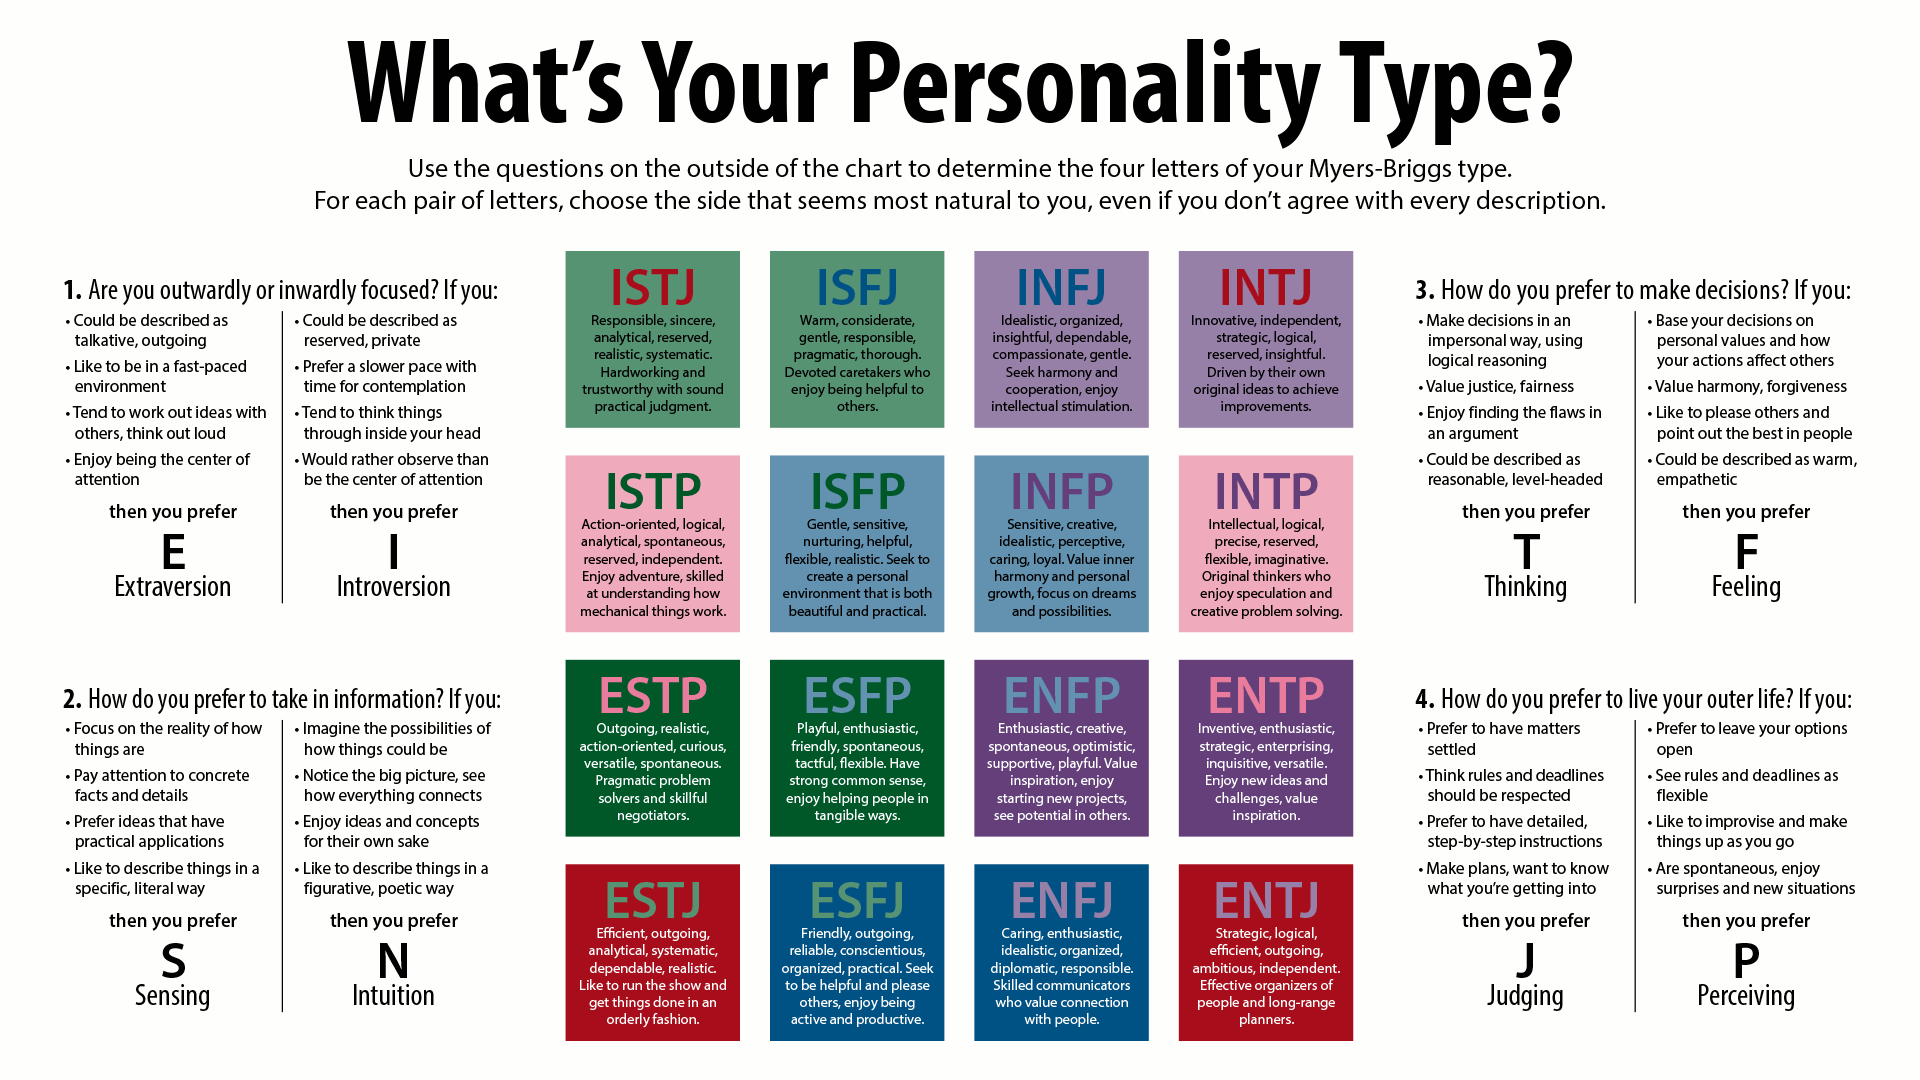

In [1]:
from IPython.display import Image
Image("../../media/MyersBriggsTypes.png")

In [2]:
# uncomment the below and run once
# ! pip install nltk scikit-learn

The website 16 personalities offers these questionanires, while also giving information about each personality type. On this website people can make accounts, and when they have done the test, their personality type appears on their user profile. Each page has a comments section and this dataset is made from exhuastively scraping all of these comments, along with their associated personality type. In addition to the 16 personalities, the website goes further to add the `-T` and `-A` types (being 'Turbulent' and 'Assertive'), meaning they actual end up tracking 32 personality types (2 to the power 5). These personality types is something we will learn about in more detail in Personalisation and Machine Learning in Term 3.

We are going to use this dataset to do some classification, looking at the many different ways we can split this dataset to see which factors of personality are most easily predicted based on. Then we will look at different ways we might try and improve our accuracy with classification.

First lets do some imports:

In [3]:
# Basic libraries
import nltk
import pandas as pd

# NLTK utils
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Bag of words
from sklearn.feature_extraction.text import CountVectorizer

# Classification stuff
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

And download these if we haven't already:

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marysia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marysia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Marysia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

Util function for part of speech tagging for lemmatisation:

In [5]:
# Function originally from: https://www.programcreek.com/python/?CodeExample=get%20wordnet%20pos
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

Now lets load and look at our data:

In [7]:
df = pd.read_csv('../../data/myers_briggs_comments.tsv', sep='\t')
df

,comment_id,personality type,source url,comment,is_reply,parent_comment_id
0,77016,INFP-A,https://www.16personalities.com/infp-strengths...,"Hello friends infp, I identify a lot with all ...",False,NaN
1,77025,ISTP-T,https://www.16personalities.com/infp-strengths...,"I can't believe how accurate this was, it's so...",False,NaN
2,77700,INFP-T,https://www.16personalities.com/infp-strengths...,We matter. I am Grace too. It is so refreshin...,True,77073.0
3,77073,INFP-T,https://www.16personalities.com/infp-strengths...,Finally I know for sure that I am not a weirdo...,False,NaN
4,77151,INFP-T,https://www.16personalities.com/infp-strengths...,I finally feel understood. I always give and g...,False,NaN
...,...,...,...,...,...,...
41695,119246,ENTP-T,https://www.16personalities.com/entp-personality,I'm such a debater I had to debate before deci...,False,NaN
41696,119900,ENTP-A,https://www.16personalities.com/entp-personality,Accurate,False,NaN
41697,121460,ENTP-A,https://www.16personalities.com/entp-personality,Debatable,True,119995.0
41698,120098,ENTP-T,https://www.16personalities.com/entp-personality,relatable,True,119995.0


We can delete the columns `comment_id` and `parent_comment_id` (we aren't going to use the columns `source url` and `is_reply`, but they may come in handy in the bonus tasks later):

In [8]:
df = df.drop('comment_id', axis=1)
df = df.drop('parent_comment_id', axis=1)
df

,personality type,source url,comment,is_reply
0,INFP-A,https://www.16personalities.com/infp-strengths...,"Hello friends infp, I identify a lot with all ...",False
1,ISTP-T,https://www.16personalities.com/infp-strengths...,"I can't believe how accurate this was, it's so...",False
2,INFP-T,https://www.16personalities.com/infp-strengths...,We matter. I am Grace too. It is so refreshin...,True
3,INFP-T,https://www.16personalities.com/infp-strengths...,Finally I know for sure that I am not a weirdo...,False
4,INFP-T,https://www.16personalities.com/infp-strengths...,I finally feel understood. I always give and g...,False
...,...,...,...,...
41695,ENTP-T,https://www.16personalities.com/entp-personality,I'm such a debater I had to debate before deci...,False
41696,ENTP-A,https://www.16personalities.com/entp-personality,Accurate,False
41697,ENTP-A,https://www.16personalities.com/entp-personality,Debatable,True
41698,ENTP-T,https://www.16personalities.com/entp-personality,relatable,True


#### Lemmatizer

Now lets run our lemmatizer on the comments:

In [9]:
lemmatizer = WordNetLemmatizer()
for index, row in df.iterrows():
    comment = str(row['comment'])
    lemmitized_comment = " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in comment.split()])
    df.loc[index, 'comment'] = lemmitized_comment
df

,personality type,source url,comment,is_reply
0,INFP-A,https://www.16personalities.com/infp-strengths...,"Hello friend infp, I identify a lot with all t...",False
1,ISTP-T,https://www.16personalities.com/infp-strengths...,"I can't believe how accurate this was, it's so...",False
2,INFP-T,https://www.16personalities.com/infp-strengths...,We matter. I be Grace too. It be so refresh kn...,True
3,INFP-T,https://www.16personalities.com/infp-strengths...,Finally I know for sure that I be not a weirdo...,False
4,INFP-T,https://www.16personalities.com/infp-strengths...,I finally feel understood. I always give and g...,False
...,...,...,...,...
41695,ENTP-T,https://www.16personalities.com/entp-personality,I'm such a debater I have to debate before dec...,False
41696,ENTP-A,https://www.16personalities.com/entp-personality,Accurate,False
41697,ENTP-A,https://www.16personalities.com/entp-personality,Debatable,True
41698,ENTP-T,https://www.16personalities.com/entp-personality,relatable,True


#### Extract classification categories


We aren't going to try and classify all 32 personality types (for now), we are just going to look at the first category (Extraversion vs Introversion). As our personality type data is structured using these handy codes, all we need to do is extract the first character from the string to do this (using `df['personality type'].str.strip().str[0]`). We will come back to this code later to try other ways of dividing our dataset.

The class `LabelEncoder` is a handy tool to then convert whatever classes we have into integer numbers starting from one (that we need to have for our classifier).

In [10]:
le = LabelEncoder()
df['feat_to_classify'] = df['personality type'].str.strip().str[0]
df['class_label'] = le.fit_transform(df['feat_to_classify'])
df

,personality type,source url,comment,is_reply,feat_to_classify,class_label
0,INFP-A,https://www.16personalities.com/infp-strengths...,"Hello friend infp, I identify a lot with all t...",False,I,1
1,ISTP-T,https://www.16personalities.com/infp-strengths...,"I can't believe how accurate this was, it's so...",False,I,1
2,INFP-T,https://www.16personalities.com/infp-strengths...,We matter. I be Grace too. It be so refresh kn...,True,I,1
3,INFP-T,https://www.16personalities.com/infp-strengths...,Finally I know for sure that I be not a weirdo...,False,I,1
4,INFP-T,https://www.16personalities.com/infp-strengths...,I finally feel understood. I always give and g...,False,I,1
...,...,...,...,...,...,...
41695,ENTP-T,https://www.16personalities.com/entp-personality,I'm such a debater I have to debate before dec...,False,E,0
41696,ENTP-A,https://www.16personalities.com/entp-personality,Accurate,False,E,0
41697,ENTP-A,https://www.16personalities.com/entp-personality,Debatable,True,E,0
41698,ENTP-T,https://www.16personalities.com/entp-personality,relatable,True,E,0


Now lets extract our comments, class labels and the associated names of our classes into Python lists:

In [11]:
comments = df["comment"].values.tolist()
class_labels = df["class_label"].values.tolist()
class_names = list(le.classes_)

#### Bag of words features

Lets fit our bag of words to our entire dataset first so that the our bag of words feature vectors are the same length in both our test and train sets:

In [12]:
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,1))
bag_of_words = vectorizer.fit_transform(comments)
vocab = vectorizer.get_feature_names_out()
print(f'Our bag of words for the whole dataset is a matrix of the shape and size {bag_of_words.shape}')

Our bag of words for the whole dataset is a matrix of the shape and size (41700, 23156)


##### Split dataset

Now lets split our dataset into **train** and **test** sets. The training set will be used to optimise our classifier on the data. The test set is used to evaluate our classifier after training. 

Here `X_train` and `X_test` are our comments. `y_train` and `y_test` are our class labels corresponding to each comment. Our classify will take the bag of words representations of our comments data as input and try to give the most accurate predictions of classes. 

It is very important that we **never evaluate a classifer on our training data**, and that **we never train on our test data**. When we do training we repeatedly optimise on that data. Therefore the accuracy in training won't give us an accurate idea of how well our classifer is performing. We can only determine a realsitic idea of accuracy on **unseen data**.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(comments, class_labels, test_size=0.3, random_state=42)

Lets redo the bag of words on the test and train with .transform() instead of .fit_transform() to ensure we use the complete vocabulary for both the test and train sets:

In [14]:
X_train_bow = vectorizer.transform(X_train)
X_train_bow

<29190x23156 sparse matrix of type '<class 'numpy.int64'>'
	with 379983 stored elements in Compressed Sparse Row format>

In [15]:
X_test_bow = vectorizer.transform(X_test)
X_test_bow

<12510x23156 sparse matrix of type '<class 'numpy.int64'>'
	with 164208 stored elements in Compressed Sparse Row format>

#### Train classifier

Now let's define what kind of classifer we are using and train it on our training data. We will give our Bag our words matrix for our entire training set, and out list of classes labels that corresponds to each row in the matrix. The classifier implementation from sci-kit learn will take care of the rest for us. 

In [16]:
classifier = MultinomialNB()
classifier.fit(X_train_bow.toarray(), y_train)

MultinomialNB()

#### Test classifier

Now we have trained our classifer we can test it. We will get the classifer to make predictions on our test dataset. We will then calucate our accuracy scores by comparing our predictions `y_pred` to our true class labels `y_test`. 

Sci-kit learn gives us a nice classification report, breaking it down into three scores, **precision**, **recall** and **f1-score**. **Precision** tells us of **True Positives / True Positive + False Positives** (how many retrieved elements are relevant). **Recall** tells us of **True Positives / True Positive + False Negatives** (how many relevant items are retrieved). The **F1-Score** tells us an average (the harmonic mean) of these two scores.


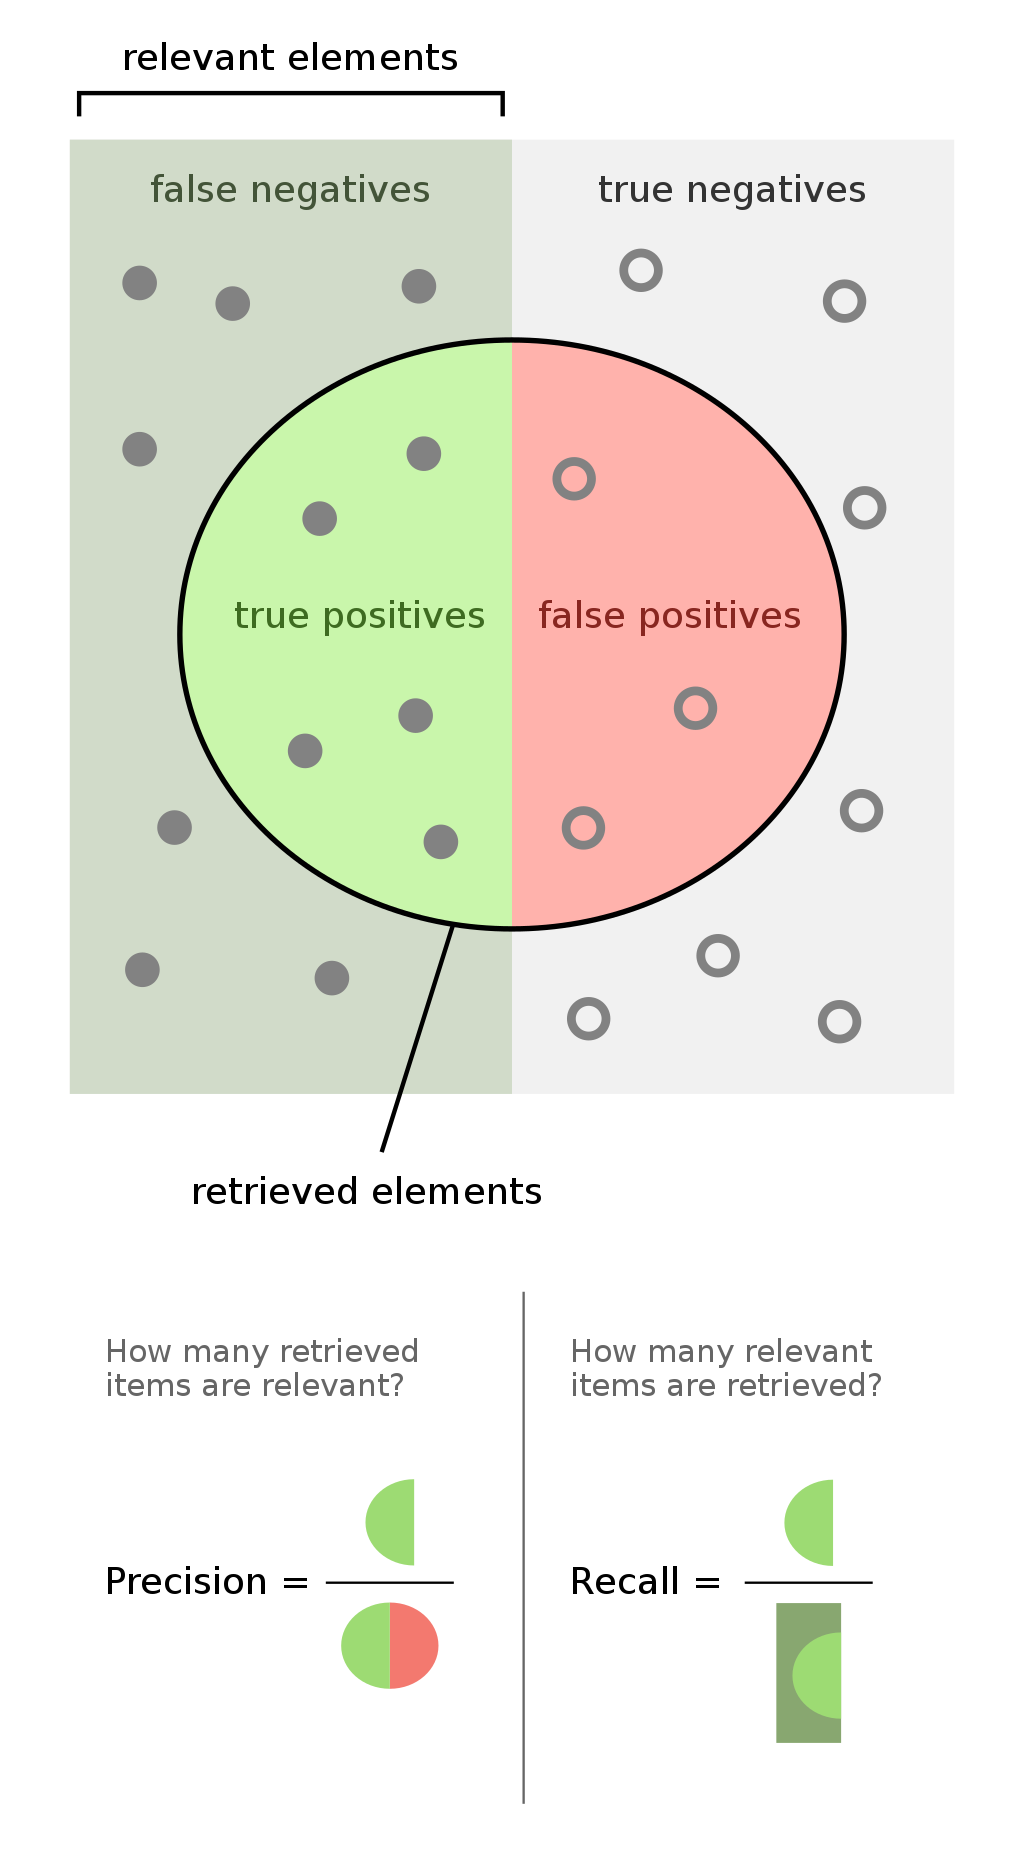

In [18]:
from IPython.display import Image
Image("../../media/precision-recall.png", width=500)

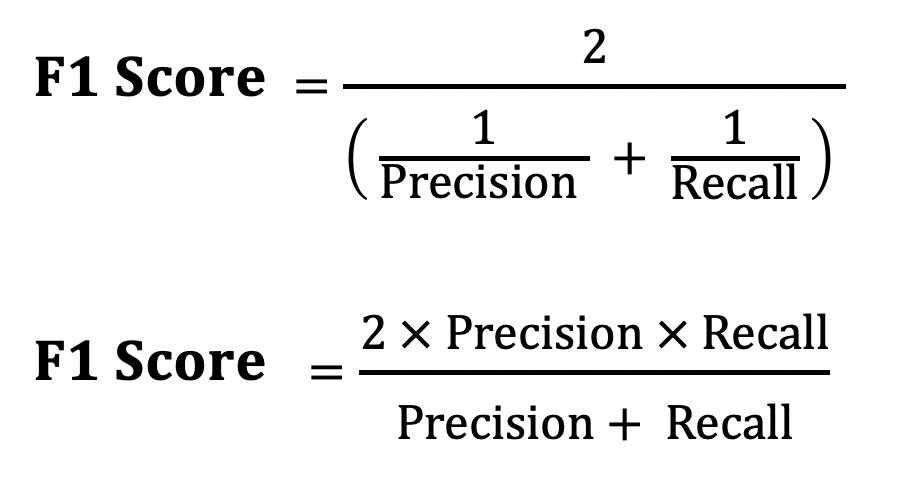

In [20]:
from IPython.display import Image
Image("../../media/f1-score.png", width=500)

There is not perfect way to measure accuracy. In some cases, you will be happy with a high recall and low precision if you want to find all possible results, and can use a human expert to check to result (i.e. if you were looking for possible cases of cancer). In other cases you may want high precision but are less bothered about having a high recall (i.e. if were deciding one of many possible stocks to buy that you want to make a profit from).

Another analogy would be if you were fishing, recall is **how big your net is** and precision is **how effective your net is at catching fish (and not other things in the sea)**.

In [21]:
y_pred = classifier.predict(X_test_bow.toarray())
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=class_names)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.7398081534772182
Classification Report:
              precision    recall  f1-score   support

           E       0.45      0.15      0.22      3150
           I       0.77      0.94      0.84      9360

    accuracy                           0.74     12510
   macro avg       0.61      0.54      0.53     12510
weighted avg       0.69      0.74      0.69     12510



## Tasks


**Task 1** Try splitting this dataset using some of the other personality distinctions, you can do this by modifying [the cell where we extract the categories we are using for classificaiton](#extract-classification-categories). Try some of the other individual binary distinctions, then see if you can train a classifer on all 16 of the original Myers-Briggs personality types. Can you then do all 32 different categories available to us in the dataset?

**Task 2** You may have noticed that we often get perfomance on one of more of the classes we have when we have a large imbalance between the numbers for each class (listed as `support` in our classification report). Try [changing the type of classifier](#train-classifier) used to another one of the [many available classifiers](https://scikit-learn.org/stable/supervised_learning.html) in sci-kit learn.

**Task 3** Can you change the code to use TF-IDF features instead of Bag of Words for classification?

**Task 4** Discuss with someone on your table:
- What are the potential uses of a text classifier trained on personality characteristics?
- What are the ethical concerns of using this dataset?
- What are the potential misuses of this dataset? 
- What are the biases present in this dataset?
- 
**Task 5 (optional) ** Run this notebook and the classification with LDA features. Which one works better? 


### Bonus tasks

**Task A** Can you filter the dataset in some way. For instance you could filter out comments that are replies (using `is_reply` in the dataset) or filter out comments that are below (or above) a certain length. The `source_url` may also be something that you use to filter out particular comments. 

**Task B** Does using a stemmer instead of a lemmatizer effect the classification scores? What happens if you don't do any pre-processing to the text?

**Task C** Can you add any stop words that are specific to this dataset? Does that improve classification results?

**Task D** Can you save the results from classification (and any other important meta-data) to a log file. This can just be an append only text file that you log the results of each experiment to, to make comparisons with later. 

**Task E** If you are doing lots of experiments using the same preprocessing to the text (stemming / lemmatisation), can you perform this and then save that dataset to a separate `.tsv` file. Which then only have to pre-process once, and then can then load directly into your code each time you runa  new experiment?

**Task F** Look for other classification datasets on [kaggle](). Can you adapt this notebook to work with a different classification dataset. You may want to make a copy of this notebook before making changes to a new dataset. 